In [249]:
import pandas as pd
import gc 
import warnings
import numpy as np
from datetime import timedelta
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster
from sklearn.cluster import KMeans
import geopandas as gpd
import seaborn as sns
from bokeh.plotting import figure, show
from datetime import timedelta
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import save, reset_output, output_notebook
from pandas.plotting import parallel_coordinates
from math import log
import datetime as dt
from folium.plugins import HeatMap
from sklearn.preprocessing import KBinsDiscretizer
import sklearn.metrics as metrics

# 1. Preprocessing the dataset for yellow dataset for 2019:  

In [252]:
file_path = r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\yellow_2019_01_04_preprocessed_3.feather"
yellow_2019_df = pd.read_feather(file_path)

## Choosing the locations to performing on the demand by ranking the size of dataset for a particular region

In [253]:
yellow_2019_df[yellow_2019_df['year'] == 2019]
yellow_2019_df['hour']  = yellow_2019_df['pick_date_time'].dt.hour
yellow_2019_df['weekday']  = yellow_2019_df['pick_date_time'].dt.weekday
yellow_2019_df["PULocationID"].value_counts().sort_values()[::-1]


237    854978
161    841682
236    826765
162    768572
234    688122
        ...  
104         1
115         1
176         1
204         1
46          1
Name: PULocationID, Length: 257, dtype: int64

## First round of Feature Engineering for the time series forecasting task

In [254]:
yellow_2019_237 = yellow_2019_df[yellow_2019_df["PULocationID"] == 237]
yellow_2019_237["time_bin_hour"]  = pd.cut(yellow_2019_237["pick_date_time"], bins=2880)
yellow_2019_237 = yellow_2019_237.drop(['PULocationID','DOLocationID','day_of_week','month_in_words'],axis = 1)
yellow_2019_237_grouping_df = yellow_2019_237.groupby("time_bin_hour").mean()
yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.drop(['index'], axis = 1)
yellow_2019_237_grouping_df['year'] = yellow_2019_237_grouping_df['year'].astype(int)
yellow_2019_237_grouping_df['month'] = yellow_2019_237_grouping_df['month'].astype(int)
yellow_2019_237_grouping_df['day'] = yellow_2019_237_grouping_df['day'].astype(int)
yellow_2019_237_grouping_df['week'] = yellow_2019_237_grouping_df['week'].astype(int)
yellow_2019_237_grouping_df['weekday'] = yellow_2019_237_grouping_df['weekday'].astype(int)
yellow_2019_237_grouping_df['hour'] = yellow_2019_237_grouping_df['hour'].astype(int)
yellow_2019_237_grouping_df['travel_duration_in_seconds'] = yellow_2019_237_grouping_df['travel_duration_in_seconds'].astype(int)
yellow_2019_237_grouping_df.head(5)

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,year,month,day,week,hour,weekday
time_bin_hour,,,,,,,,,,,,,,,
"(2018-12-31 21:08:49.600999936, 2019-01-01 00:59:40.930208256]",1.670213,2.067589,9.698582,2.240567,13.237376,12.458827,5.431296,0.249206,638,2019,1,1,1,0,1
"(2019-01-01 00:59:40.930208256, 2019-01-01 01:59:10.860416768]",1.746377,2.479891,10.842391,2.413261,14.607283,12.651584,5.108188,0.230607,715,2019,1,1,1,1,1
"(2019-01-01 01:59:10.860416768, 2019-01-01 02:58:40.790625024]",1.558140,2.353566,9.965116,2.144651,13.445349,13.992693,5.202503,0.228386,604,2019,1,1,1,1,1
"(2019-01-01 02:58:40.790625024, 2019-01-01 03:58:10.720833280]",1.789474,2.558421,10.333333,2.286140,13.910702,15.400600,4.642555,0.227293,607,2019,1,1,1,2,1
"(2019-01-01 03:58:10.720833280, 2019-01-01 04:57:40.651041792]",2.068966,3.113448,11.275862,2.266552,15.438276,18.557337,4.398957,0.229319,576,2019,1,1,1,3,1


## Assign each trip with a time bin in the period of 2019/01-2019-/04 with each time bin has the interval of 1 hour


In [255]:
yellow_count_df = pd.DataFrame(yellow_2019_237['time_bin_hour'].value_counts())
yellow_count_df['frequency'] =  yellow_count_df['time_bin_hour'] 
yellow_count_df= yellow_count_df.drop(['time_bin_hour'] , axis = 1)
yellow_count_df = yellow_count_df.reset_index()
yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.reset_index()
yellow_2019_237_grouping_df = pd .merge(yellow_count_df,yellow_2019_237_grouping_df,\
                                        left_on = 'index' ,\
                                        right_on = 'time_bin_hour')
yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.drop('index', axis = 1).set_index('time_bin_hour')

## Feature Engineering

In [256]:
yellow_2019_237_grouping_df['indicator_peak_hours']  = yellow_2019_237_grouping_df['hour'].map(lambda x: 1 if x in [9,10,11,12,13,14,15,16,17,18,19,20] else 0)
yellow_2019_237_grouping_df['indicator_weekends']  = yellow_2019_237_grouping_df['weekday'].map(lambda x: 1 if x in [5,6] else 0)
yellow_2019_237_grouping_df.head()                                                        

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,year,month,day,week,hour,weekday,indicator_peak_hours,indicator_weekends
time_bin_hour,,,,,,,,,,,,,,,,,,
"(2019-04-25 17:48:27.188541696, 2019-04-25 18:47:57.118749952]",802,1.557357,1.574788,9.493142,2.456297,16.259090,8.636411,7.041923,0.285199,726,2019,4,25,17,17,3,1,0
"(2019-03-06 17:54:51.636458240, 2019-03-06 18:54:21.566666752]",778,1.619537,1.652172,9.222365,2.457866,16.000938,8.936332,6.606290,0.286147,680,2019,3,6,10,17,2,1,0
"(2019-01-29 18:11:22.424999936, 2019-01-29 19:10:52.355208448]",777,1.498069,1.528069,8.862934,1.998082,12.664994,8.369449,6.923804,0.238105,661,2019,1,29,5,18,1,1,0
"(2019-03-07 17:42:49.961458432, 2019-03-07 18:42:19.891666688]",768,1.524740,1.562357,9.034505,2.413828,15.748203,8.850831,6.646415,0.285483,672,2019,3,7,10,17,3,1,0
"(2019-02-06 17:34:38.955208448, 2019-02-06 18:34:08.885416704]",751,1.619174,1.553222,9.340213,2.505379,16.158202,8.279520,6.957398,0.286805,721,2019,2,6,6,17,2,1,0


## Create columns that keep the demand from the past

In [257]:
yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.sort_values(["time_bin_hour"],ascending =  False)
yellow_2019_237_grouping_df['t+1 frequency'] = yellow_2019_237_grouping_df.loc[:,'frequency'].shift(periods=1)

yellow_2019_237_grouping_df['t-1 frequency'] = yellow_2019_237_grouping_df.loc[:,'frequency'].shift(periods=-1)
yellow_2019_237_grouping_df['t-1 frequency_diff'] = yellow_2019_237_grouping_df.loc[:,'t-1 frequency'].diff(periods = -1)


yellow_2019_237_grouping_df['t-2 frequency'] = yellow_2019_237_grouping_df.loc[:,'t-1 frequency'].shift(periods=-1)
yellow_2019_237_grouping_df['t-2 frequency_diff'] = yellow_2019_237_grouping_df.loc[:,'t-2 frequency'].diff(periods = -1)

yellow_2019_237_grouping_df['t-3 frequency'] = yellow_2019_237_grouping_df.loc[:,'t-2 frequency'].shift(periods=-1)
yellow_2019_237_grouping_df['t-3 frequency_diff'] = yellow_2019_237_grouping_df.loc[:,'t-3 frequency'].diff(periods = -1)

yellow_2019_237_grouping_df['t-4 frequency'] = yellow_2019_237_grouping_df.loc[:,'t-3 frequency'].shift(periods=-1)
yellow_2019_237_grouping_df['t-4 frequency_diff'] = yellow_2019_237_grouping_df.loc[:,'t-4 frequency'].diff(periods = -1)


yellow_2019_237_grouping_df['t-5 frequency'] = yellow_2019_237_grouping_df.loc[:,'t-4 frequency'].shift(periods=-1)
yellow_2019_237_grouping_df['t-5 frequency_diff'] = yellow_2019_237_grouping_df.loc[:,'t-5 frequency'].diff(periods = -1)


yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.dropna()

In [258]:
yellow_2019_237_grouping_df.to_csv(r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\yellow_2019_237_grouping_df.csv")

##  Creating the cllumns that store the moving average, max and minimum, maximum and variance

In [259]:
yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.sort_values("time_bin_hour", ascending = True)
yellow_2019_237_grouping_df.head(5)

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,...,t-1 frequency,t-1 frequency_diff,t-2 frequency,t-2 frequency_diff,t-3 frequency,t-3 frequency_diff,t-4 frequency,t-4 frequency_diff,t-5 frequency,t-5 frequency_diff
time_bin_hour,,,,,,,,,,,,,,,,,,,,,
"(2019-01-01 05:57:10.581250048, 2019-01-01 06:56:40.511458304]",12,1.333333,3.013333,10.458333,2.450000,14.710000,20.790391,4.528795,0.229908,443,...,14.0,-15.0,29.0,-28.0,57.0,-72.0,129.0,-147.0,276.0,-6.0
"(2019-01-01 06:56:40.511458304, 2019-01-01 07:56:10.441666560]",19,1.736842,2.183158,8.710526,1.785263,11.902105,16.428371,5.219994,0.207347,405,...,12.0,-2.0,14.0,-15.0,29.0,-28.0,57.0,-72.0,129.0,-147.0
"(2019-01-01 07:56:10.441666560, 2019-01-01 08:55:40.371875072]",37,1.702703,2.589189,9.945946,2.160541,12.920000,18.083037,5.158214,0.221935,475,...,19.0,7.0,12.0,-2.0,14.0,-15.0,29.0,-28.0,57.0,-72.0
"(2019-01-01 08:55:40.371875072, 2019-01-01 09:55:10.302083328]",48,1.416667,2.127292,8.687500,1.931875,11.659375,16.033342,5.467236,0.230760,419,...,37.0,18.0,19.0,7.0,12.0,-2.0,14.0,-15.0,29.0,-28.0
"(2019-01-01 09:55:10.302083328, 2019-01-01 10:54:40.232291584]",85,1.564706,2.384471,9.523529,2.156824,12.683647,15.883750,5.329101,0.234682,481,...,48.0,11.0,37.0,18.0,19.0,7.0,12.0,-2.0,14.0,-15.0


In [260]:
yellow_2019_237_grouping_df["24_hours_average"] = yellow_2019_237_grouping_df["frequency"].rolling(24, min_periods = 1).mean()
yellow_2019_237_grouping_df["72_hours_average"] = yellow_2019_237_grouping_df["frequency"].rolling(72, min_periods = 1).mean()
yellow_2019_237_grouping_df["5_days_average"] = yellow_2019_237_grouping_df["frequency"].rolling(120, min_periods = 1).mean()
yellow_2019_237_grouping_df["24_hours_average_max"] = yellow_2019_237_grouping_df["frequency"].rolling(24, min_periods = 1).max()
yellow_2019_237_grouping_df["72_hours_average_max"] = yellow_2019_237_grouping_df["frequency"].rolling(72, min_periods = 1).max()
yellow_2019_237_grouping_df["5_days_average_max"] = yellow_2019_237_grouping_df["frequency"].rolling(120, min_periods = 1).max()
yellow_2019_237_grouping_df["24_hours_average_min"] = yellow_2019_237_grouping_df["frequency"].rolling(24, min_periods = 1).min()
yellow_2019_237_grouping_df["72_hours_average_min"] = yellow_2019_237_grouping_df["frequency"].rolling(72, min_periods = 1).min()
yellow_2019_237_grouping_df["5_days_average_min"] = yellow_2019_237_grouping_df["frequency"].rolling(120, min_periods = 1).min()
yellow_2019_237_grouping_df["24_hours_average_std"] = yellow_2019_237_grouping_df["frequency"].rolling(24, min_periods = 1).std()
yellow_2019_237_grouping_df["72_hours_average_std"] = yellow_2019_237_grouping_df["frequency"].rolling(72, min_periods = 1).std()
yellow_2019_237_grouping_df["5_days_average_std"] = yellow_2019_237_grouping_df["frequency"].rolling(120, min_periods = 1).std()


In [261]:
yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.drop(['year','month'], axis = 1)
yellow_2019_237_grouping_df = yellow_2019_237_grouping_df.dropna()

In [262]:
yellow_2019_237_grouping_df.to_csv(r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\yellow_2019_237_grouping_df.csv")

# 1. Preprocessing the dataset for yellow dataset for 2020, with the same setup as the 2019 dataset

In [263]:
file_path = r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2020\yellow_taxi_2020\yellow_2020_01_04_preprocessed_3.feather"
yellow_2020_df = pd.read_feather(file_path)

In [264]:
yellow_2020_df.head(10)

,index,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,tip_amount,total_amount,pick_date_time,drop_date_time,...,travel_duration_in_seconds,year,month,date,day,time,week,day_of_week,month_in_words,Borough
0,0,1.0,1.20,238,239,6.0,1.47,11.27,2020-01-01 00:28:15+00:00,2020-01-01 00:33:03+00:00,...,288,2020,1,2020-01-01,1,00:28:15,1,Wednesday,Jan,Manhattan
1,1,1.0,2.46,238,161,9.5,2.56,15.36,2020-01-23 06:28:12+00:00,2020-01-23 06:37:54+00:00,...,582,2020,1,2020-01-23,23,06:28:12,4,Thursday,Jan,Manhattan
2,2,1.0,4.71,238,244,16.0,3.86,23.16,2020-01-23 06:50:55+00:00,2020-01-23 07:02:51+00:00,...,716,2020,1,2020-01-23,23,06:50:55,4,Thursday,Jan,Manhattan
3,3,1.0,1.41,238,236,7.0,1.00,11.30,2020-01-23 06:32:10+00:00,2020-01-23 06:38:38+00:00,...,388,2020,1,2020-01-23,23,06:32:10,4,Thursday,Jan,Manhattan
4,4,1.0,1.52,238,142,6.0,1.86,11.16,2020-01-23 06:31:27+00:00,2020-01-23 06:35:09+00:00,...,222,2020,1,2020-01-23,23,06:31:27,4,Thursday,Jan,Manhattan
5,5,1.0,6.61,238,13,21.0,2.00,26.30,2020-01-23 06:56:34+00:00,2020-01-23 07:14:38+00:00,...,1084,2020,1,2020-01-23,23,06:56:34,4,Thursday,Jan,Manhattan
6,6,1.0,0.55,238,238,5.0,1.66,9.96,2020-01-09 10:59:06+00:00,2020-01-09 11:04:08+00:00,...,302,2020,1,2020-01-09,9,10:59:06,2,Thursday,Jan,Manhattan
7,7,1.0,7.85,238,128,24.5,6.95,34.75,2020-01-23 06:10:41+00:00,2020-01-23 06:28:40+00:00,...,1079,2020,1,2020-01-23,23,06:10:41,4,Thursday,Jan,Manhattan
8,8,1.0,1.78,238,143,8.0,2.26,13.56,2020-01-23 06:44:17+00:00,2020-01-23 06:52:10+00:00,...,473,2020,1,2020-01-23,23,06:44:17,4,Thursday,Jan,Manhattan
9,9,1.0,2.10,238,142,9.5,2.56,15.36,2020-01-23 06:45:38+00:00,2020-01-23 06:55:11+00:00,...,573,2020,1,2020-01-23,23,06:45:38,4,Thursday,Jan,Manhattan


## Choosing the locations to performing on the demand by ranking the size of dataset for a particular region

In [265]:
yellow_2020_df[yellow_2020_df['year'] == 2019]
yellow_2020_df['hour']  = yellow_2020_df['pick_date_time'].dt.hour
yellow_2020_df['weekday']  = yellow_2020_df['pick_date_time'].dt.weekday
yellow_2020_df["PULocationID"].value_counts().sort_values()[::-1]
yellow_2020_237 = yellow_2020_df[yellow_2020_df["PULocationID"] == 237]
yellow_2020_237["time_bin_hour"]  = pd.cut(yellow_2020_237["pick_date_time"], bins=2880)
yellow_2020_237 = yellow_2020_237.drop(['PULocationID','DOLocationID','day_of_week','month_in_words'],axis = 1)


In [266]:
yellow_2020_237_grouping_df = yellow_2020_237.groupby("time_bin_hour").mean()
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.drop(['index'], axis = 1)
yellow_2020_237_grouping_df.head()
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.dropna()


In [267]:
yellow_2020_237_grouping_df['year'] = yellow_2020_237_grouping_df['year'].astype(int)
yellow_2020_237_grouping_df['month'] = yellow_2020_237_grouping_df['month'].astype(int)
yellow_2020_237_grouping_df['day'] = yellow_2020_237_grouping_df['day'].astype(int)
yellow_2020_237_grouping_df['week'] = yellow_2020_237_grouping_df['week'].astype(int)
yellow_2020_237_grouping_df['weekday'] = yellow_2020_237_grouping_df['weekday'].astype(int)
yellow_2020_237_grouping_df['hour'] = yellow_2020_237_grouping_df['hour'].astype(int)
yellow_2020_237_grouping_df['travel_duration_in_seconds'] = yellow_2020_237_grouping_df['travel_duration_in_seconds'].astype(int)
yellow_2020_237_grouping_df.head(5)

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,year,month,day,week,hour,weekday
time_bin_hour,,,,,,,,,,,,,,,
"(2019-12-31 21:09:43.640999936, 2020-01-01 01:02:28.082985984]",1.614243,1.985905,9.416914,2.721899,15.938813,11.954609,5.562297,0.308880,619,2020,1,1,1,0,2
"(2020-01-01 01:02:28.082985984, 2020-01-01 02:02:27.165972224]",1.688963,2.184448,9.989967,2.622475,16.433177,12.022917,5.410377,0.285822,651,2020,1,1,1,1,2
"(2020-01-01 02:02:27.165972224, 2020-01-01 03:02:26.248958208]",1.761905,2.185646,9.312925,2.418639,15.544830,14.048207,5.171784,0.281474,546,2020,1,1,1,2,2
"(2020-01-01 03:02:26.248958208, 2020-01-01 04:02:25.331944448]",1.160000,2.584000,10.280000,2.571800,16.651800,15.088663,4.894941,0.286351,575,2020,1,1,1,3,2
"(2020-01-01 04:02:25.331944448, 2020-01-01 05:02:24.414930432]",1.611111,2.143889,9.000000,2.212222,15.012222,14.800505,4.583492,0.249173,521,2020,1,1,1,4,2


In [268]:
yellow_count_df = pd.DataFrame(yellow_2020_237['time_bin_hour'].value_counts())
yellow_count_df['frequency'] =  yellow_count_df['time_bin_hour'] 
yellow_count_df= yellow_count_df.drop(['time_bin_hour'] , axis = 1)
yellow_count_df = yellow_count_df.reset_index()
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.reset_index()
yellow_2020_237_grouping_df = pd .merge(yellow_count_df,yellow_2020_237_grouping_df,\
                                        left_on = 'index' ,\
                                        right_on = 'time_bin_hour')
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.drop('index', axis = 1).set_index('time_bin_hour')

In [269]:
yellow_2020_237_grouping_df['indicator_peak_hours']  = yellow_2020_237_grouping_df['hour'].map(lambda x: 1 if x in [9,10,11,12,13,14,15,16,17,18,19,20] else 0)
yellow_2020_237_grouping_df['indicator_weekends']  = yellow_2020_237_grouping_df['weekday'].map(lambda x: 1 if x in [5,6] else 0)
yellow_2020_237_grouping_df.head()                                                        

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,year,month,day,week,hour,weekday,indicator_peak_hours,indicator_weekends
time_bin_hour,,,,,,,,,,,,,,,,,,
"(2020-03-03 14:39:30.728124928, 2020-03-03 15:39:29.811111168]",769,1.442133,1.414746,9.564369,2.359376,15.247399,6.388667,8.077266,0.260700,777,2020,3,3,10,14,1,1,0
"(2020-03-06 17:38:21.952083456, 2020-03-06 18:38:21.035069440]",756,1.484127,1.577778,9.615741,2.514590,16.466720,7.741210,7.062343,0.281920,761,2020,3,6,10,17,4,1,0
"(2020-03-05 17:38:43.960416768, 2020-03-05 18:38:43.043402752]",717,1.520223,1.671060,9.695258,2.535481,16.564184,8.458151,6.689051,0.281989,745,2020,3,5,10,17,3,1,0
"(2020-02-12 17:46:48.143749888, 2020-02-12 18:46:47.226736128]",701,1.483595,1.613738,9.213980,2.426961,15.940870,8.608922,6.744137,0.282248,688,2020,2,12,7,17,2,1,0
"(2020-02-27 14:41:20.769791744, 2020-02-27 15:41:19.852777728]",698,1.553009,1.437436,8.914756,2.255802,14.477722,7.656727,7.114847,0.267930,677,2020,2,27,9,14,3,1,0


## More Feature Engineering for time series forecasting

In [270]:
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.sort_values(["time_bin_hour"],ascending =  False)
yellow_2020_237_grouping_df['t+1 frequency'] = yellow_2020_237_grouping_df.loc[:,'frequency'].shift(periods=1)

yellow_2020_237_grouping_df['t-1 frequency'] = yellow_2020_237_grouping_df.loc[:,'frequency'].shift(periods=-1)
yellow_2020_237_grouping_df['t-1 frequency_diff'] = yellow_2020_237_grouping_df.loc[:,'t-1 frequency'].diff(periods = -1)


yellow_2020_237_grouping_df['t-2 frequency'] = yellow_2020_237_grouping_df.loc[:,'t-1 frequency'].shift(periods=-1)
yellow_2020_237_grouping_df['t-2 frequency_diff'] = yellow_2020_237_grouping_df.loc[:,'t-2 frequency'].diff(periods = -1)

yellow_2020_237_grouping_df['t-3 frequency'] = yellow_2020_237_grouping_df.loc[:,'t-2 frequency'].shift(periods=-1)
yellow_2020_237_grouping_df['t-3 frequency_diff'] = yellow_2020_237_grouping_df.loc[:,'t-3 frequency'].diff(periods = -1)

yellow_2020_237_grouping_df['t-4 frequency'] = yellow_2020_237_grouping_df.loc[:,'t-3 frequency'].shift(periods=-1)
yellow_2020_237_grouping_df['t-4 frequency_diff'] = yellow_2020_237_grouping_df.loc[:,'t-4 frequency'].diff(periods = -1)


yellow_2020_237_grouping_df['t-5 frequency'] = yellow_2020_237_grouping_df.loc[:,'t-4 frequency'].shift(periods=-1)
yellow_2020_237_grouping_df['t-5 frequency_diff'] = yellow_2020_237_grouping_df.loc[:,'t-5 frequency'].diff(periods = -1)


yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.dropna()

In [271]:
yellow_2020_237_grouping_df.to_csv(r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2020\yellow_taxi_2020\yellow_2020_237_grouping_df.csv")

##  Creating the cllumns that store the moving average, max and minimum, maximum and variance


In [272]:
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.sort_values("time_bin_hour", ascending = True)
yellow_2020_237_grouping_df.head(5)

,frequency,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,average_speed,average_fare,tip_fare_r,travel_duration_in_seconds,...,t-1 frequency,t-1 frequency_diff,t-2 frequency,t-2 frequency_diff,t-3 frequency,t-3 frequency_diff,t-4 frequency,t-4 frequency_diff,t-5 frequency,t-5 frequency_diff
time_bin_hour,,,,,,,,,,,,,,,,,,,,,
"(2020-01-01 06:02:23.497916672, 2020-01-01 07:02:22.580902656]",14,2.214286,3.336429,11.642857,3.140714,19.395000,18.772564,4.740704,0.305794,528,...,15.0,-3.0,18.0,-32.0,50.0,-97.0,147.0,-152.0,299.0,-38.0
"(2020-01-01 07:02:22.580902656, 2020-01-01 08:02:21.663888896]",19,1.315789,2.588421,9.605263,2.740000,15.967368,19.509814,5.027127,0.303730,429,...,14.0,-1.0,15.0,-3.0,18.0,-32.0,50.0,-97.0,147.0,-152.0
"(2020-01-01 08:02:21.663888896, 2020-01-01 09:02:20.746874880]",29,1.551724,2.245862,8.810345,2.354483,14.675862,17.509535,5.448008,0.278933,425,...,19.0,5.0,14.0,-1.0,15.0,-3.0,18.0,-32.0,50.0,-97.0
"(2020-01-01 09:02:20.746874880, 2020-01-01 10:02:19.829861120]",52,1.903846,2.182885,8.903846,2.410769,14.887500,16.600917,5.039667,0.295733,447,...,29.0,10.0,19.0,5.0,14.0,-1.0,15.0,-3.0,18.0,-32.0
"(2020-01-01 10:02:19.829861120, 2020-01-01 11:02:18.912847104]",91,1.637363,1.786484,7.851648,2.123846,13.364176,16.002623,5.081980,0.281440,407,...,52.0,23.0,29.0,10.0,19.0,5.0,14.0,-1.0,15.0,-3.0


In [273]:
yellow_2020_237_grouping_df["24_hours_average"] = yellow_2020_237_grouping_df["frequency"].rolling(24, min_periods = 1).mean()
yellow_2020_237_grouping_df["72_hours_average"] = yellow_2020_237_grouping_df["frequency"].rolling(72, min_periods = 1).mean()
yellow_2020_237_grouping_df["5_days_average"] = yellow_2020_237_grouping_df["frequency"].rolling(120, min_periods = 1).mean()
yellow_2020_237_grouping_df["24_hours_average_max"] = yellow_2020_237_grouping_df["frequency"].rolling(24, min_periods = 1).max()
yellow_2020_237_grouping_df["72_hours_average_max"] = yellow_2020_237_grouping_df["frequency"].rolling(72, min_periods = 1).max()
yellow_2020_237_grouping_df["5_days_average_max"] = yellow_2020_237_grouping_df["frequency"].rolling(120, min_periods = 1).max()
yellow_2020_237_grouping_df["24_hours_average_min"] = yellow_2020_237_grouping_df["frequency"].rolling(24, min_periods = 1).min()
yellow_2020_237_grouping_df["72_hours_average_min"] = yellow_2020_237_grouping_df["frequency"].rolling(72, min_periods = 1).min()
yellow_2020_237_grouping_df["5_days_average_min"] = yellow_2020_237_grouping_df["frequency"].rolling(120, min_periods = 1).min()
yellow_2020_237_grouping_df["24_hours_average_std"] = yellow_2020_237_grouping_df["frequency"].rolling(24, min_periods = 1).std()
yellow_2020_237_grouping_df["72_hours_average_std"] = yellow_2020_237_grouping_df["frequency"].rolling(72, min_periods = 1).std()
yellow_2020_237_grouping_df["5_days_average_std"] = yellow_2020_237_grouping_df["frequency"].rolling(120, min_periods = 1).std()


In [274]:
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.drop(['year','month'], axis = 1)
yellow_2020_237_grouping_df = yellow_2020_237_grouping_df.dropna()

In [275]:
yellow_2020_237_grouping_df.to_csv(r"F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2020\yellow_taxi_2020\yellow_2020_237_groupng_df.csv")

# Start Modelling

In [276]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC,SVR
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression

# One hot encoding for the catergorical variables

In [277]:
df = pd.get_dummies(yellow_2019_237_grouping_df, columns  =  ['day','week','hour','weekday'])

## Create the training set and test set

In [278]:
y_train = df["t+1 frequency"]
X_train = df.drop("t+1 frequency",axis = 1)

In [279]:
X_train.shape
date_data = []
for i in X_train.reset_index()['time_bin_hour']:
    date_data.append(i.left)
date_df_2019 = pd.DataFrame({'date':date_data})
date_df_2019


,date
0,2019-01-01 06:56:40.511458304+00:00
1,2019-01-01 07:56:10.441666560+00:00
2,2019-01-01 08:55:40.371875072+00:00
3,2019-01-01 09:55:10.302083328+00:00
4,2019-01-01 10:54:40.232291584+00:00
...,...
2867,2019-04-29 17:59:50.418749952+00:00
2868,2019-04-29 18:59:20.348958208+00:00
2869,2019-04-29 19:58:50.279166720+00:00
2870,2019-04-29 20:58:20.209374976+00:00


In [281]:
df.to_csv(r'F:\Ads_projects\project1\mast30034_2021_s2_project_1-junzhin\data\2019\yellow_taxi_2019\training_dataset.csv')
training_set = np.array(X_train)
targets = np.array(y_train)

# The Random Forrest

#  Cross_validation for all results

## Entire dataSet for Training

------------------------------
mapE:
0.2806915066709747
rseM:
2226.550650842912


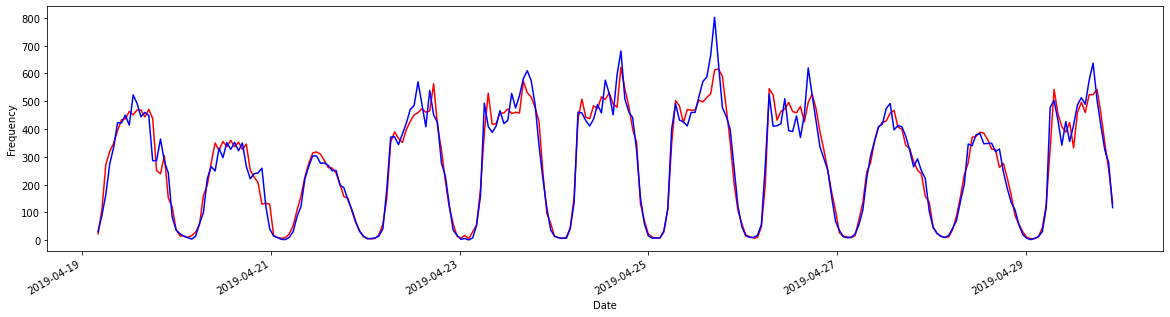

In [342]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(training_set):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr = RandomForestRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton_entire = regr.predict(X_test)
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton_entire)
     RSME_result = mean_squared_error(y_test, y_prediciton_entire,squared = True)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

print("---"*10)
print("mapE:")
print(sum(MAPE_results)/len(MAPE_results))
print("rseM:")
print(sum(RSME_results)/len(MAPE_results))

fig = plt.figure(figsize = (20,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_prediciton_entire),color ='red')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_test),color ='blue')
fig.autofmt_xdate()


# Select the K-best features using the metric of chisquare

In [285]:
select_20 = SelectKBest(mutual_info_regression, k = 20)
select_60 = SelectKBest(mutual_info_regression, k = 60)
select_90 = SelectKBest(mutual_info_regression, k = 90)


In [286]:
X_20 = select_20.fit_transform(X_train, y_train)
X_60 = select_60.fit_transform(X_train, y_train)
X_90 = select_90.fit_transform(X_train, y_train)


In [287]:
data = {"features":np.array(X_train.columns),"score":np.array(select_20.scores_)}
score_list = pd.DataFrame(data)

In [288]:
score_list.sort_values("score", ascending=False)[:20]

,features,score
0,frequency,1.063586
6,average_speed,0.757244
7,average_fare,0.680549
12,t-1 frequency,0.645187
2,trip_distance,0.492265
14,t-2 frequency,0.440687
16,t-3 frequency,0.379029
17,t-3 frequency_diff,0.330030
13,t-1 frequency_diff,0.317362
1,passenger_count,0.307473


## 60-features dataset for training

------------------------------
mapE:
0.29565761660108975
rseM:
2236.0955822222218


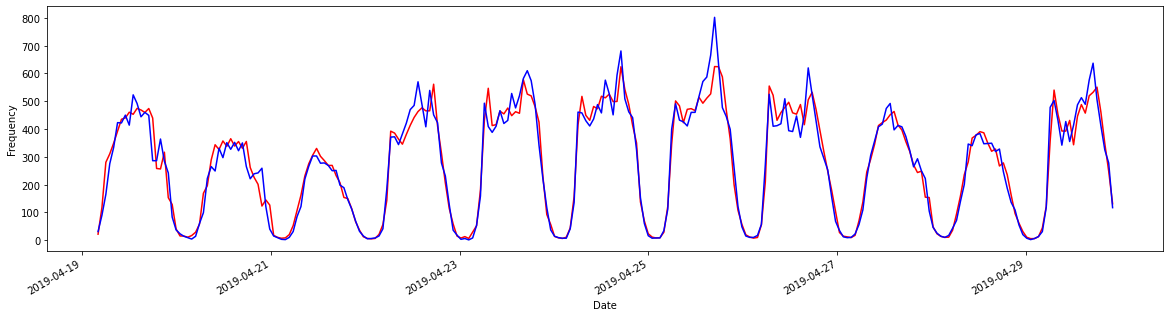

In [289]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(X_60):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr60 = RandomForestRegressor()
     results = regr60.fit(X_t, y_t)
     y_prediciton_60 = regr60.predict(X_test)
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton_60)
     RSME_result = mean_squared_error(y_test, y_prediciton_60,squared = True)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

print("---"*10)
print("mapE:")
print(sum(MAPE_results)/len(MAPE_results))
print("rseM:")
print(sum(RSME_results)/len(MAPE_results))


fig = plt.figure(figsize = (20,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_prediciton_60),color ='red')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_test),color ='blue')
fig.autofmt_xdate()

## 90-features for training

------------------------------
mapE:
0.28472651966395185
rseM:
2264.8032771264366


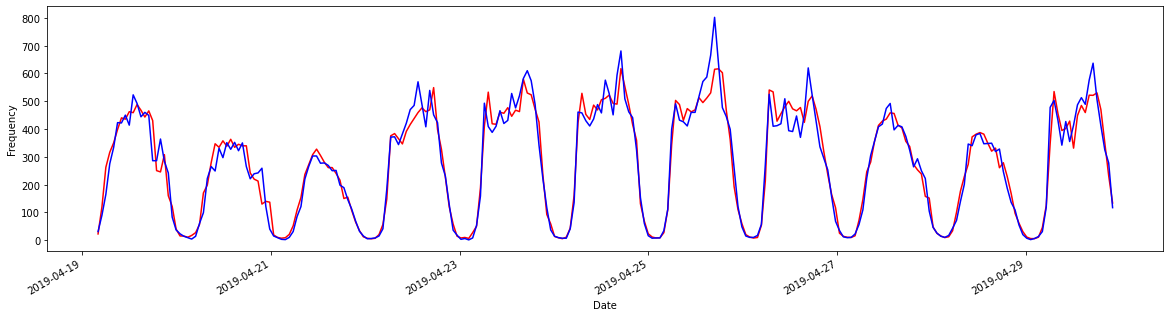

In [290]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(X_90):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr90 = RandomForestRegressor()
     results = regr90.fit(X_t, y_t)
     y_prediciton_90 = regr90.predict(X_test)
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton_90)
     RSME_result = mean_squared_error(y_test, y_prediciton_90,squared = True)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

print("---"*10)
print("mapE:")
print(sum(MAPE_results)/len(MAPE_results))
print("rseM:")
print(sum(RSME_results)/len(MAPE_results))

fig = plt.figure(figsize = (20,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_prediciton_90),color ='red')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_test),color ='blue')
fig.autofmt_xdate()

## 20-features dataset for training

------------------------------
mapE:
0.2968546017393737
rseM:
2255.0987923754783


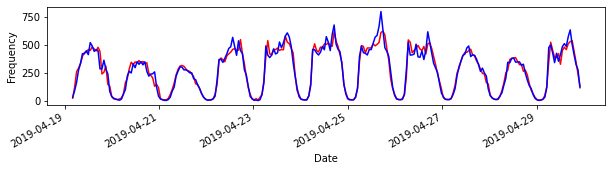

In [324]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(X_20):
     X_t = training_set[train_index]
     y_t = targets[train_index] 
     X_test = training_set[test_index]
     y_test = targets[test_index] 
     regr20 = RandomForestRegressor()
     results = regr20.fit(X_t, y_t)
     y_prediciton_20= regr20.predict(X_test)
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton_20)
     RSME_result = mean_squared_error(y_test, y_prediciton_20,squared = True)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

print("---"*10)
print("mapE:")
print(sum(MAPE_results)/len(MAPE_results))
print("rseM:")
print(sum(RSME_results)/len(MAPE_results))


fig = plt.figure(figsize = (10,2))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_prediciton_20),color ='red')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_test),color ='blue')
fig.autofmt_xdate()


# Unseen test set of 2020 for the models 

In [292]:
df_2 = pd.get_dummies(yellow_2020_237_grouping_df, columns  =  ['day','week','hour','weekday'])
y_valid = df_2["t+1 frequency"]
X_valid = df_2.drop("t+1 frequency",axis = 1)
X_valid_transformed = select_90.transform(X_valid)

In [293]:
date_data = []
for i in df_2.reset_index()['time_bin_hour']:
    date_data.append(i.left)
date_df_2020 = pd.DataFrame({'date':date_data})
date_df_2020['date'].dt.date


0       2020-01-01
1       2020-01-01
2       2020-01-01
3       2020-01-01
4       2020-01-01
           ...    
2671    2020-04-29
2672    2020-04-29
2673    2020-04-29
2674    2020-04-29
2675    2020-04-29
Name: date, Length: 2676, dtype: object

# Entire Training set unseen test set Performance

In [343]:

y_prediction = regr.predict(X_valid)
MAPE_result = mean_absolute_percentage_error(y_valid,y_prediction)
RSME_result = mean_squared_error(y_valid, y_prediction,squared = True)

print(MAPE_result)
print(RSME_result)

5.374327398872568
2350.9842223467863


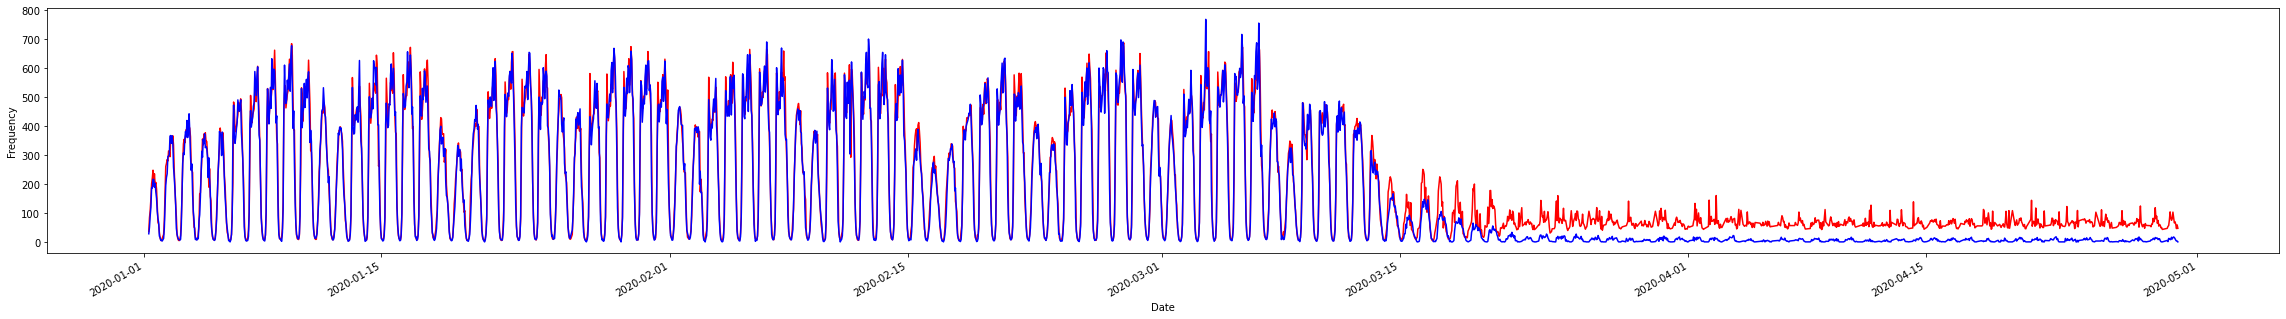

In [ ]:
fig = plt.figure(figsize = (40,5))
plt.plot(np.array(date_df_2020),np.array(y_prediction),color ='red')
plt.plot(np.array(date_df_2020),np.array(y_valid),color ='blue')
plt.xlabel("Date")
plt.ylabel('Frequency')
fig.autofmt_xdate()



# 60 features Training set unseen test set  Performance

In [334]:

y_prediction60 = regr60.predict(X_valid)
MAPE_result = mean_absolute_percentage_error(y_valid,y_prediction60)
RSME_result = mean_squared_error(y_valid, y_prediction60,squared = True)

print(MAPE_result)
print(RSME_result)

5.048870201640219
2249.2553380418535


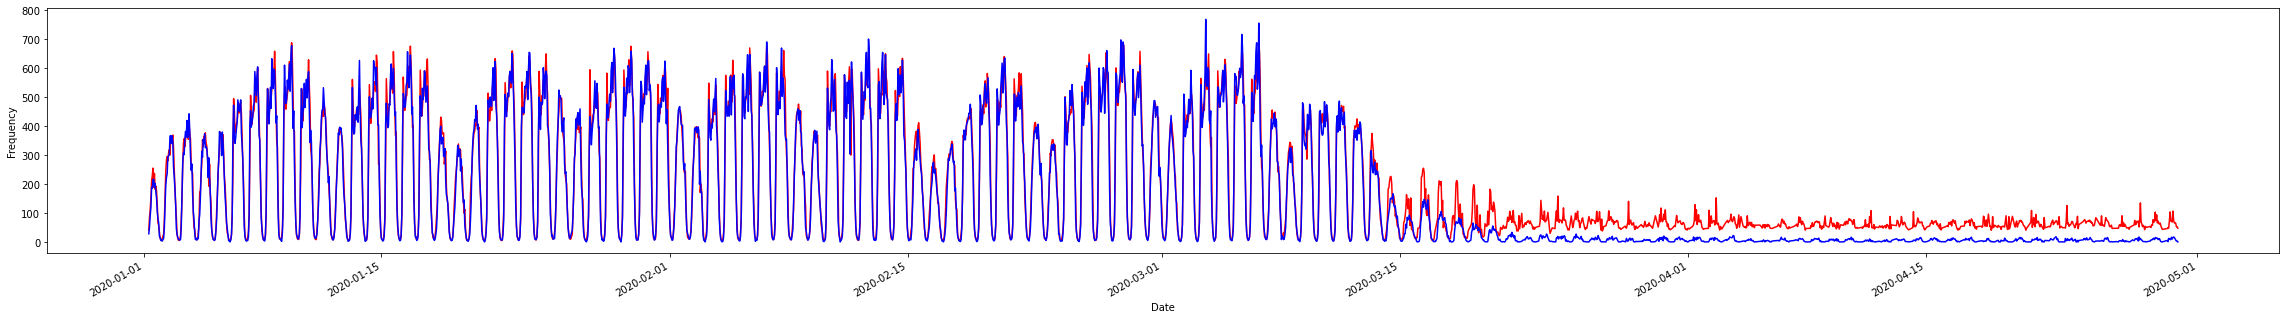

In [335]:
fig = plt.figure(figsize = (40,5))
plt.plot(np.array(date_df_2020),np.array(y_prediction60),color ='red')
plt.plot(np.array(date_df_2020),np.array(y_valid),color ='blue')
plt.xlabel("Date")
plt.ylabel('Frequency')
fig.autofmt_xdate()



# 90 features Training set unseen test set Performance

In [336]:

y_prediction90 = regr90.predict(X_valid)
MAPE_result = mean_absolute_percentage_error(y_valid,y_prediction90)
RSME_result = mean_squared_error(y_valid, y_prediction90,squared = True)

print(MAPE_result)
print(RSME_result)

5.296757440202002
2309.9966768310915


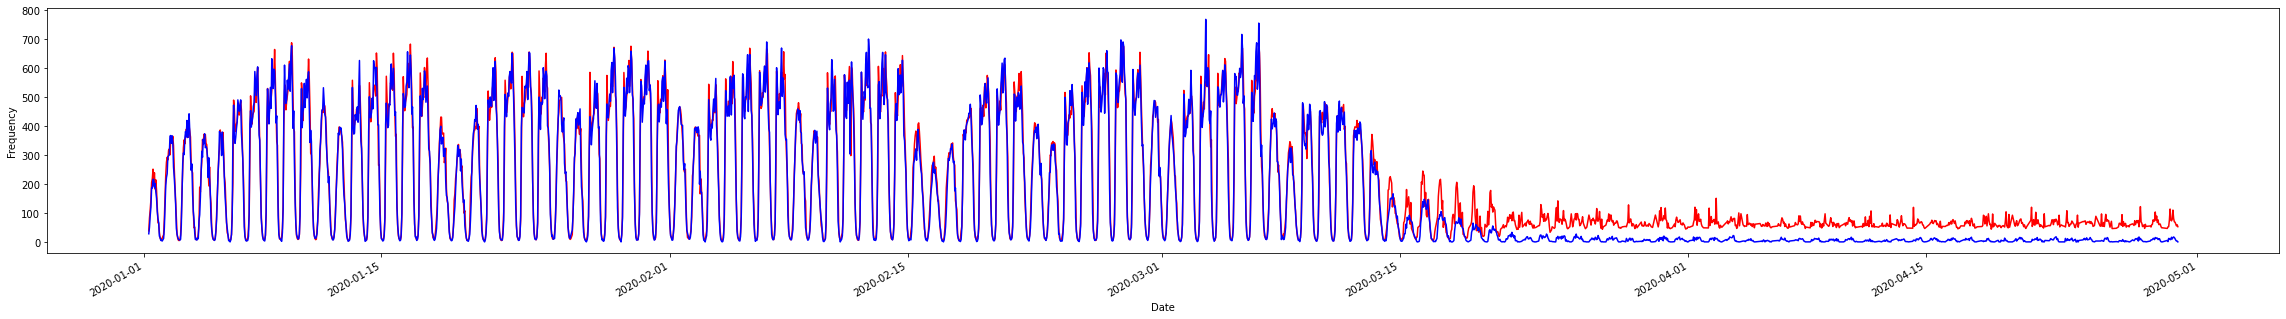

In [337]:
fig = plt.figure(figsize = (40,5))
plt.plot(np.array(date_df_2020),np.array(y_prediction90),color ='red')
plt.plot(np.array(date_df_2020),np.array(y_valid),color ='blue')
plt.xlabel("Date")
plt.ylabel('Frequency')
fig.autofmt_xdate()



# 20 features Training set unseen test set Performance

In [338]:
y_prediction20 = regr20.predict(X_valid)
MAPE_result = mean_absolute_percentage_error(y_valid,y_prediction20)
RSME_result = mean_squared_error(y_valid, y_prediction20,squared = True)

print(MAPE_result)
print(RSME_result)

5.117831912889401
2244.8276016442455


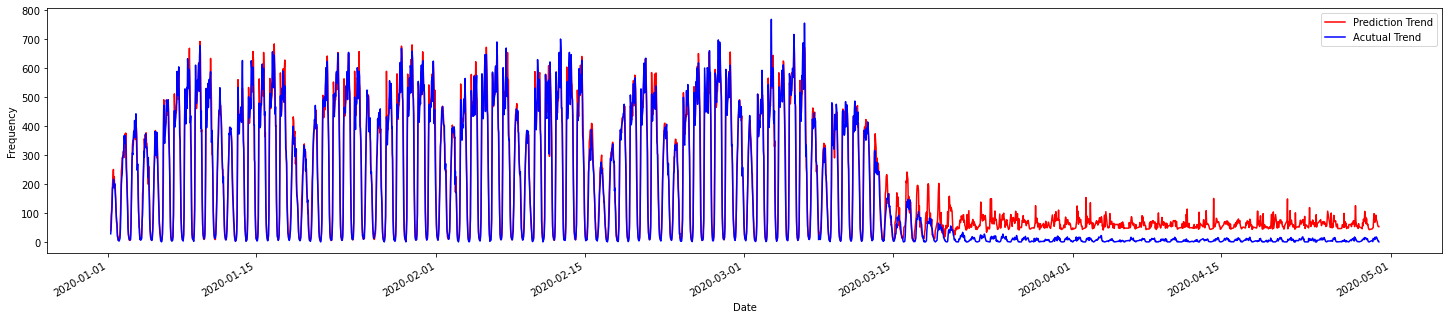

In [355]:
fig = plt.figure(figsize = (25,5))
plt.plot(np.array(date_df_2020),np.array(y_prediction20),color ='red',label = "Prediction Trend" )
plt.plot(np.array(date_df_2020),np.array(y_valid),color ='blue', label = "Acutual Trend")
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.legend()
fig.autofmt_xdate()




# Comparsion between different models using the sizes of features with a selected period after the pandemic outbreak

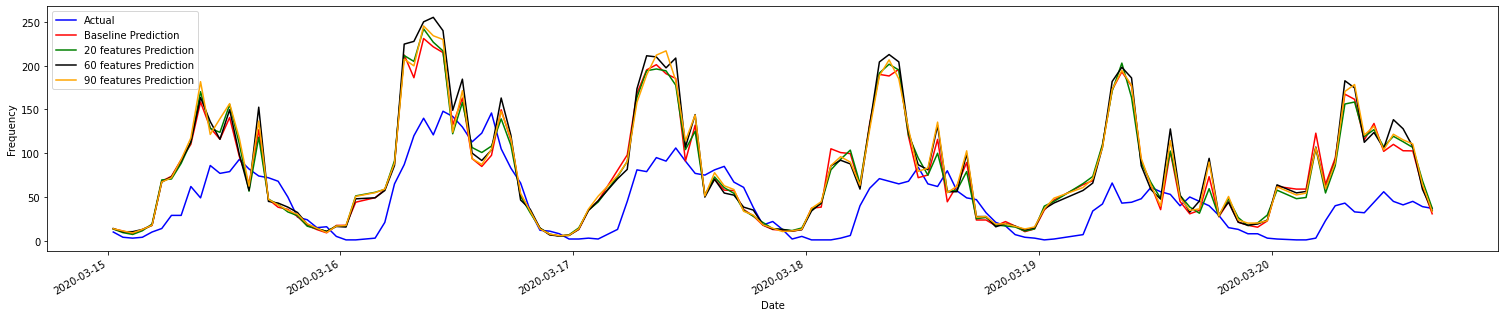

In [356]:
fig = plt.figure(figsize = (26,5))
plt.plot(np.array(date_df_2020[1768:1900]),np.array(y_valid[1768:1900]),color ='blue',label = "Actual")
plt.plot(np.array(date_df_2020[1768:1900]),np.array(y_prediction[1768:1900]),color ='red', label = "Baseline Prediction")
plt.plot(np.array(date_df_2020[1768:1900]),np.array(y_prediction20[1768:1900]),color ='green', label = "20 features Prediction")
plt.plot(np.array(date_df_2020[1768:1900]),np.array(y_prediction60[1768:1900]),color ='black', label = "60 features Prediction")
plt.plot(np.array(date_df_2020[1768:1900]),np.array(y_prediction90[1768:1900]),color ='orange', label = "90 features Prediction")
plt.xlabel("Date")
plt.legend()
plt.ylabel('Frequency')
fig.autofmt_xdate()



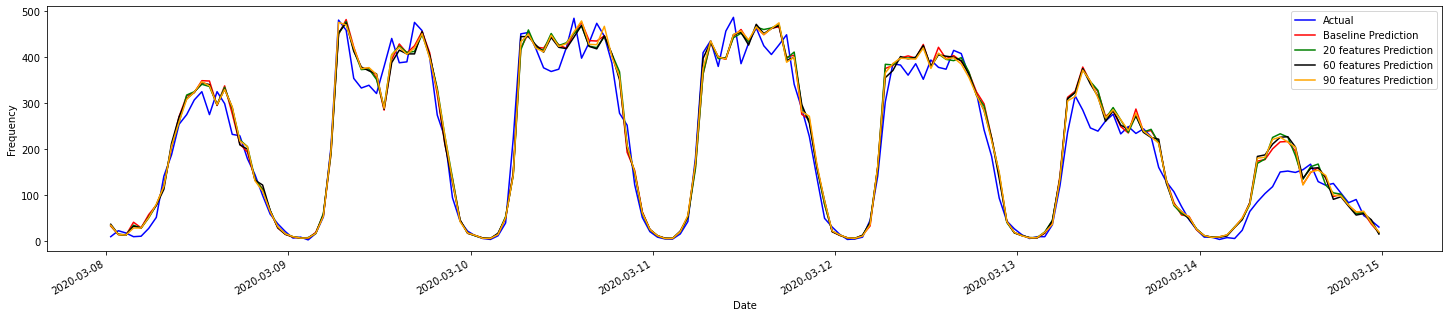

In [352]:
fig = plt.figure(figsize = (25,5))
plt.plot(np.array(date_df_2020[1600:1768]),np.array(y_valid[1600:1768]),color ='blue',label = "Actual")
plt.plot(np.array(date_df_2020[1600:1768]),np.array(y_prediction[1600:1768]),color ='red', label = "Baseline Prediction")
plt.plot(np.array(date_df_2020[1600:1768]),np.array(y_prediction20[1600:1768]),color ='green', label = "20 features Prediction")
plt.plot(np.array(date_df_2020[1600:1768]),np.array(y_prediction60[1600:1768]),color ='black', label = "60 features Prediction")
plt.plot(np.array(date_df_2020[1600:1768]),np.array(y_prediction90[1600:1768]),color ='orange', label = "90 features Prediction")
plt.xlabel("Date")
plt.legend()
plt.ylabel('Frequency')
fig.autofmt_xdate()


In [303]:
# Find the cut point before the outbreak of COVID_2019 and lockdown in NYC
date_df_2020[date_df_2020['date'] > '2020-03-15']

,date
1768,2020-03-15 00:35:19.466319360+00:00
1769,2020-03-15 01:35:18.549305600+00:00
1770,2020-03-15 02:35:17.632291584+00:00
1771,2020-03-15 03:35:16.715277824+00:00
1772,2020-03-15 04:35:15.798263808+00:00
...,...
2671,2020-04-29 16:18:34.419097344+00:00
2672,2020-04-29 17:18:33.502083328+00:00
2673,2020-04-29 18:18:32.585069568+00:00
2674,2020-04-29 19:18:31.668055552+00:00


# Entire dataset training after excluding the period of the pandemic starting from 2020-3-15 in new york city


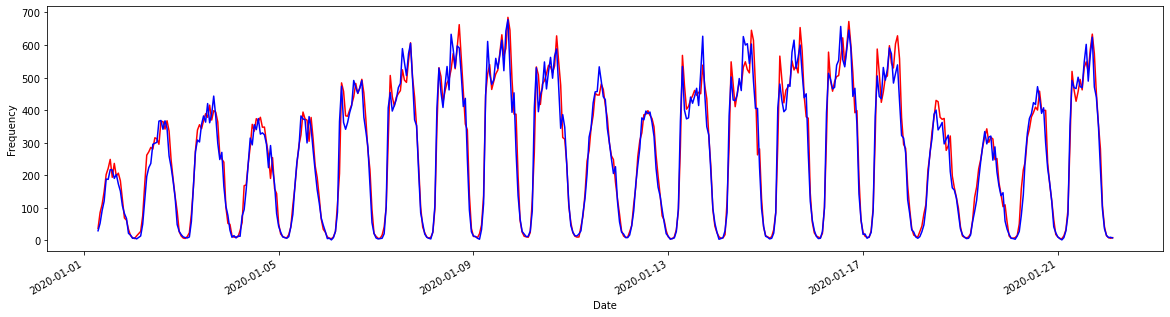

In [330]:
fig = plt.figure(figsize = (30,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2020)[:500],np.array(y_prediction)[:500],color ='red')
plt.plot(np.array(date_df_2020)[:500],np.array(y_valid)[:500],color ='blue')
fig.autofmt_xdate()


In [305]:
y_prediction = regr.predict(X_valid[:1649])
MAPE_result_valid = mean_absolute_percentage_error(y_valid[:1649],y_prediction)
RSME_result_valid = mean_squared_error(y_valid[:1649], y_prediction,squared = True)
print(MAPE_result)
print(RSME_result)

4.955763749611762
2208.526322907324


# 90 features training after excluding the period of the pandemic starting from 2020-3-15 in new york city

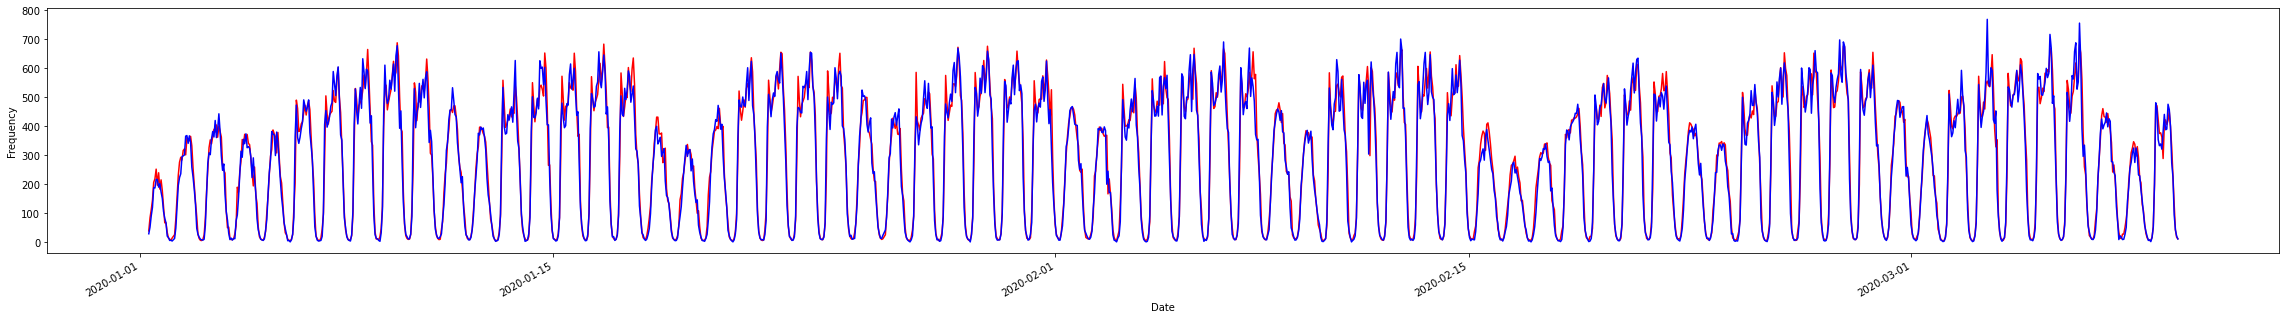

In [306]:
fig = plt.figure(figsize = (40,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2020)[:1649],np.array(y_prediction90)[:1649],color ='red')
plt.plot(np.array(date_df_2020)[:1649],np.array(y_valid)[:1649],color ='blue')
fig.autofmt_xdate()


In [307]:
y_prediction90 = regr90.predict(X_valid[:1649])
MAPE_result_valid90 = mean_absolute_percentage_error(y_valid[:1649],y_prediction90)
RSME_result_valid90 = mean_squared_error(y_valid[:1649], y_prediction90,squared = True)
print(MAPE_result)
print(RSME_result)

4.955763749611762
2208.526322907324


# 60 features training after excluding the period of the pandemic starting from 2020-3-15 in new york city

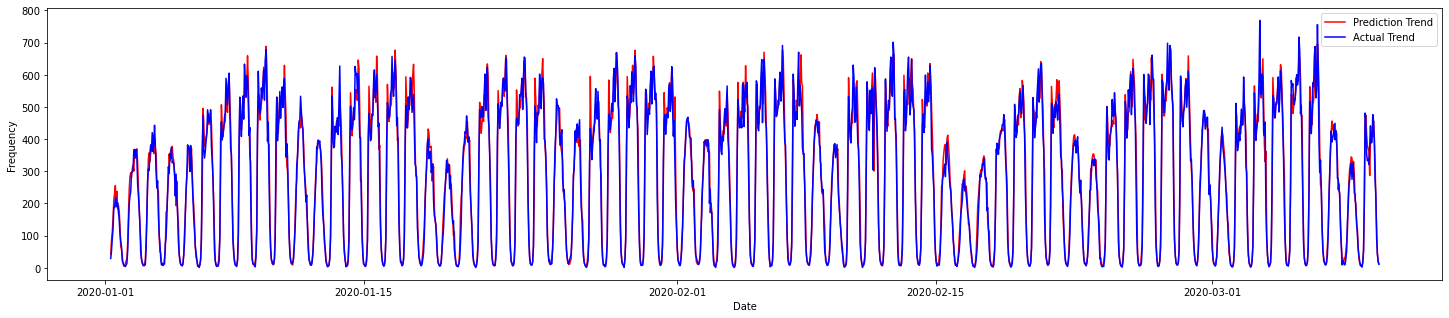

In [308]:
fig = plt.figure(figsize = (25,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2020)[:1649],np.array(y_prediction60)[:1649],color ='red',label = "Prediction Trend")
plt.plot(np.array(date_df_2020)[:1649],np.array(y_valid)[:1649],color ='blue', label = "Actual Trend")
plt.legend()

In [309]:
y_prediction60 = regr60.predict(X_valid[:1649])
MAPE_result_valid60 = mean_absolute_percentage_error(y_valid[:1649],y_prediction60)
RSME_result_valid60 = mean_squared_error(y_valid[:1649], y_prediction60,squared = True)
print(MAPE_result)
print(RSME_result)

4.955763749611762
2208.526322907324


# 20 features training after excluding the period of the pandemic starting from 2020-3-15 in new york city

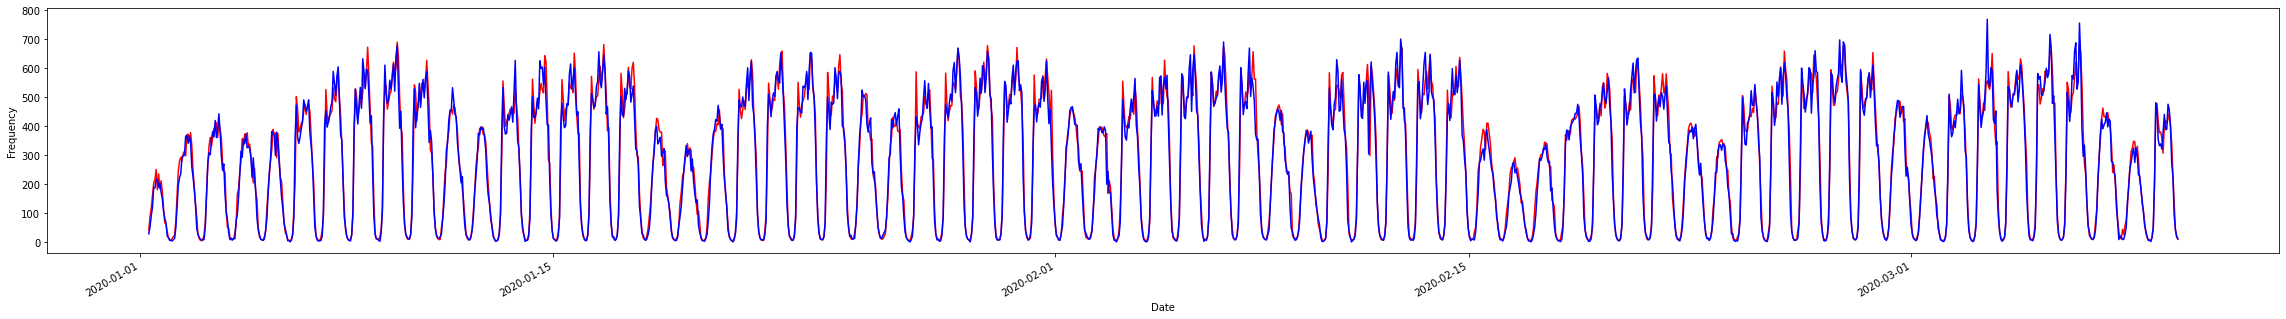

In [310]:
fig = plt.figure(figsize = (40,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2020)[:1649],np.array(y_prediction20)[:1649],color ='red')
plt.plot(np.array(date_df_2020)[:1649],np.array(y_valid)[:1649],color ='blue')
fig.autofmt_xdate()


In [311]:
y_prediction20 = regr20.predict(X_valid[:1649])
MAPE_result_valid20 = mean_absolute_percentage_error(y_valid[:1649],y_prediction20)
RSME_result_valid20 = mean_squared_error(y_valid[:1649], y_prediction20,squared = True)
print(MAPE_result)
print(RSME_result)

4.955763749611762
2208.526322907324


# Summary Graphs before and after the feature engineering

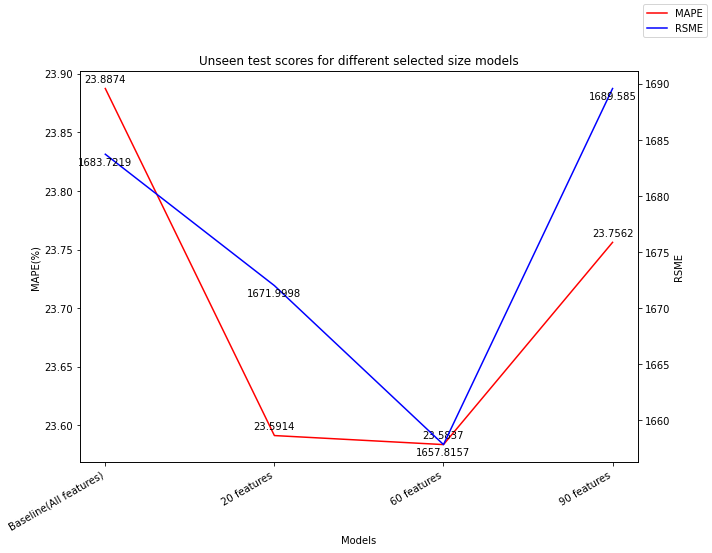

In [358]:
fig, ax1 = plt.subplots(figsize = (10,8))
plt.title("Unseen test scores for different selected size models")
ax2 = ax1.twinx()
x =  ["Baseline(All features)","20 features","60 features","90 features"]
y = [round(i*100,4) for i in[MAPE_result_valid,MAPE_result_valid20,MAPE_result_valid60,MAPE_result_valid90]]
y2 = [round(i,4) for i in[RSME_result_valid,RSME_result_valid20,RSME_result_valid60,RSME_result_valid90]]
ax1.plot(x,y,color ='red', label = 'MAPE')
ax2.plot(x,y2,color ='blue',label = 'RSME')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAPE(%)')
ax2.set_ylabel('RSME')

for i in range(len(x)):
    ax1.text(i, y[i]+0.005, y[i], ha = 'center')
    ax2.text(i, y2[i]- 1, y2[i], ha = 'center')

fig.legend(loc="upper right")


fig.autofmt_xdate()

plt.show()


# Tree_based feature Selection based on mse     

In [313]:
df_feature_importance = pd.DataFrame({'features':np.array(X_train.columns),'score':np.array(regr.feature_importances_)})
df_feature_importance = df_feature_importance.sort_values("score", ascending = False).reset_index(drop =True)
df_feature_importance.head(20)

,features,score
0,frequency,0.688383
1,average_speed,0.125417
2,t-1 frequency_diff,0.044771
3,t-5 frequency,0.035928
4,average_fare,0.019692
5,hour_6,0.010565
6,t-4 frequency,0.008920
7,t-2 frequency,0.007381
8,trip_distance,0.006882
9,t-3 frequency_diff,0.006038


## Features of importance top 10 based on tree-based

<BarContainer object of 10 artists>

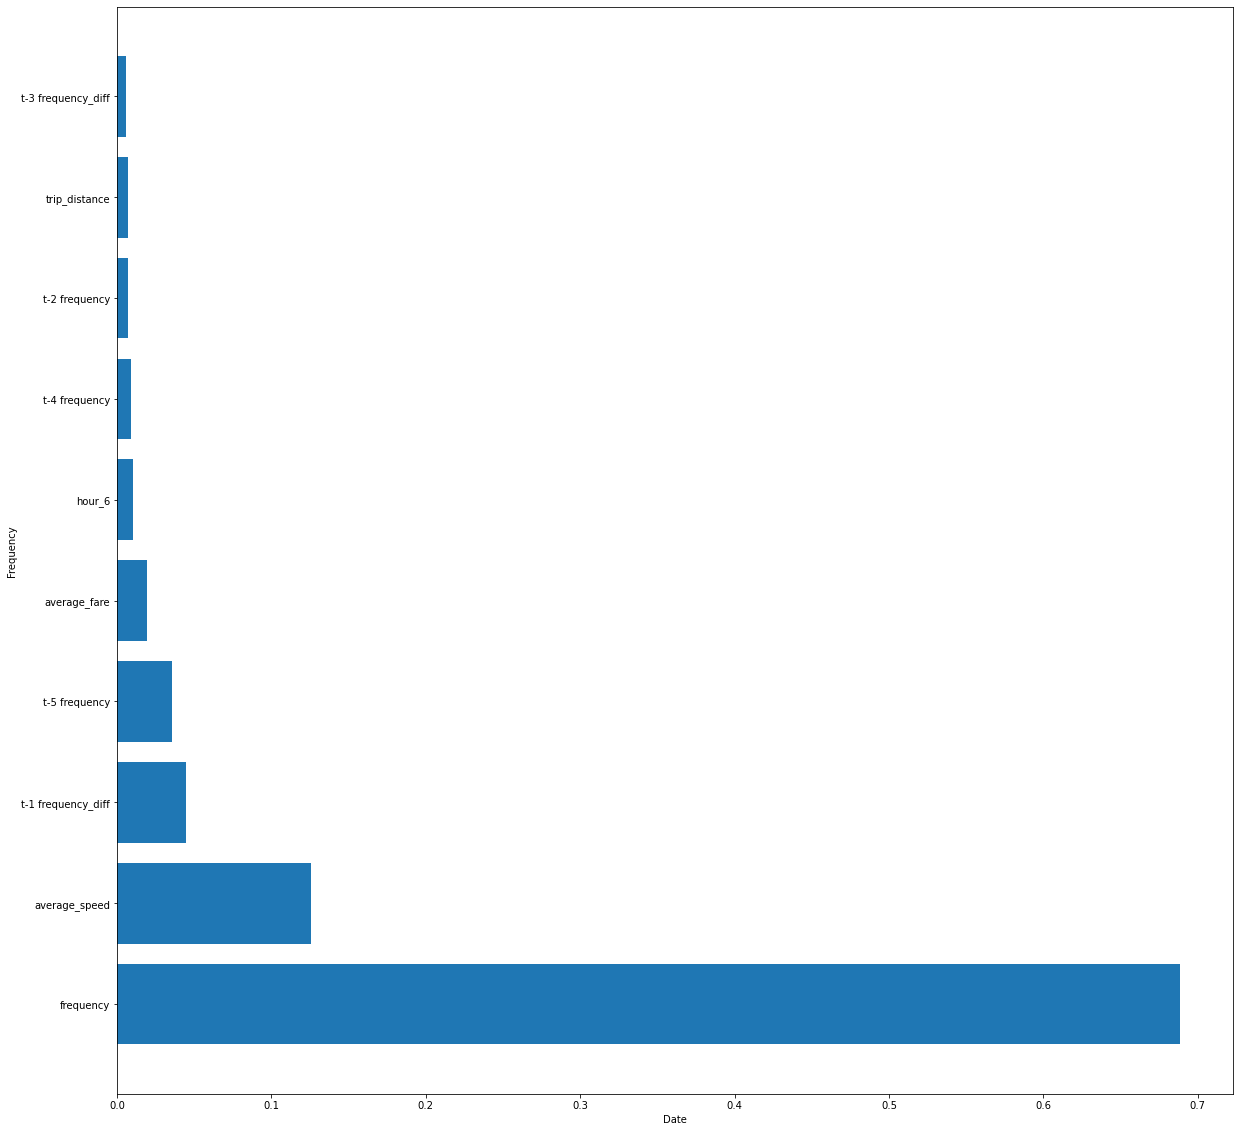

In [314]:
fig = plt.figure(figsize = (20,20))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.barh(df_feature_importance.features[:10],df_feature_importance.score[:10],)

# 20 features training using the tree-based selection

In [362]:
X_train_20_tb = X_train.loc[:,df_feature_importance.loc[:20,'features']]

In [363]:
X_train_20_tb = np.array(X_train_20_tb)

------------------------------
mapE:
0.2909307158667092
rseM:
2264.044962183908


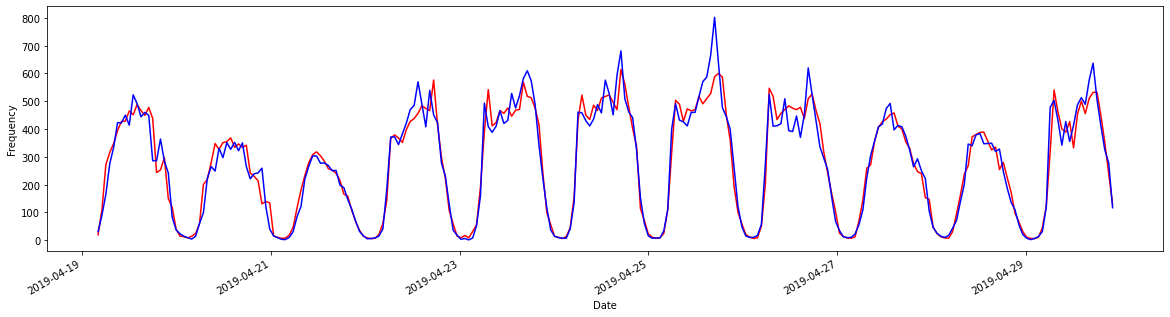

In [364]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(X_train_20_tb):
     X_t = X_train_20_tb[train_index]
     y_t = y_train[train_index] 
     X_test = X_train_20_tb[test_index]
     y_test = y_train[test_index] 
     regr = RandomForestRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton_20tb = regr.predict(X_test)
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton_20tb)
     RSME_result = mean_squared_error(y_test, y_prediciton_20tb,squared = True)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

print("---"*10)
print("mapE:")
print(sum(MAPE_results)/len(MAPE_results))
print("rseM:")
print(sum(RSME_results)/len(MAPE_results))

fig = plt.figure(figsize = (20,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_prediciton_20tb),color ='red')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_test),color ='blue')
fig.autofmt_xdate()


In [365]:
X_valid_20_tb = X_valid.loc[:,df_feature_importance.loc[:20,'features']]
y_prediciton_20tb = regr.predict(X_valid_20_tb[:1649])
MAPE_result_20tb = mean_absolute_percentage_error(y_valid[:1649],y_prediciton_20tb)
RSME_result_20tb = mean_squared_error(y_valid[:1649], y_prediciton_20tb,squared = True)
print(MAPE_result_20tb)
print(RSME_result_20tb)

0.24533510432152633
1789.90164978775


# 90 features training using the tree-based selection

In [366]:
X_train_90_tb = X_train.loc[:,df_feature_importance.loc[:90,'features']]
X_train_90_tb = np.array(X_train_90_tb)

------------------------------
mapE:
0.28498801875696045
rseM:
2242.2524198467436


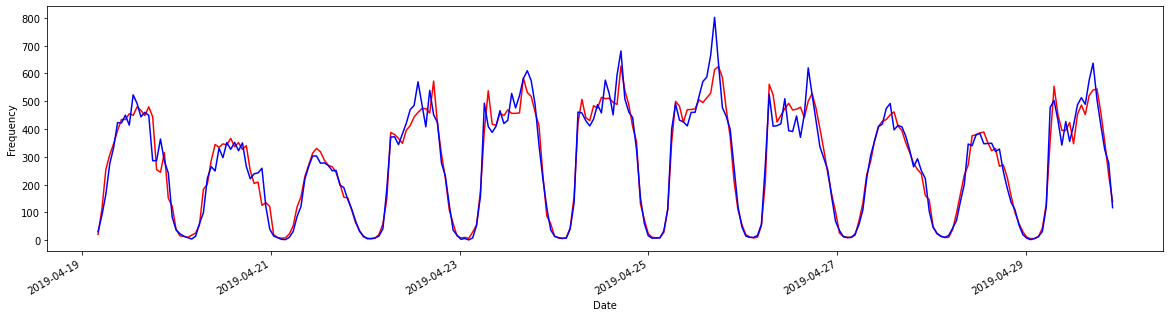

In [367]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(X_train_90_tb):
     X_t = X_train_90_tb[train_index]
     y_t = y_train[train_index] 
     X_test = X_train_90_tb[test_index]
     y_test = y_train[test_index] 
     regr = RandomForestRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton_90tb = regr.predict(X_test)
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton_90tb)
     RSME_result = mean_squared_error(y_test, y_prediciton_90tb,squared = True)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

print("---"*10)
print("mapE:")
print(sum(MAPE_results)/len(MAPE_results))
print("rseM:")
print(sum(RSME_results)/len(RSME_results))

fig = plt.figure(figsize = (20,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_prediciton_90tb),color ='red')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_test),color ='blue')
fig.autofmt_xdate()


In [368]:
X_valid_90_tb = X_valid.loc[:,df_feature_importance.loc[:90,'features']]
y_prediciton_90tb = regr.predict(X_valid_90_tb[:1649])
MAPE_result_90tb = mean_absolute_percentage_error(y_valid[:1649],y_prediciton_90tb)
RSME_result_90tb = mean_squared_error(y_valid[:1649], y_prediciton_90tb,squared = True)
print(MAPE_result_90tb)
print(RSME_result_90tb)

0.24188453603240523
1674.1210180109156


# 60 features training using the tree-based selection

In [369]:
X_train_60_tb = X_train.loc[:,df_feature_importance.loc[:60,'features']]
X_train_60_tb = np.array(X_train_60_tb)

------------------------------
mapE:
0.2905226904781053
rseM:
2238.759992183908


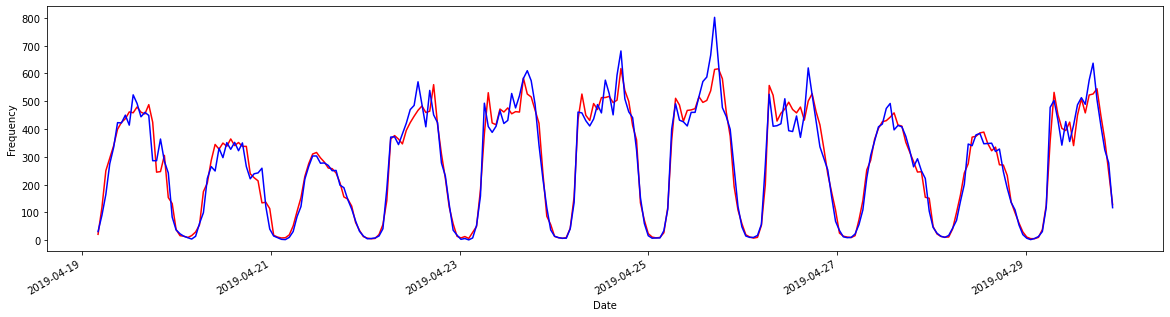

In [370]:
tscv = TimeSeriesSplit(n_splits=10)
MAPE_results  = []
RSME_results  = []

for train_index, test_index in tscv.split(X_train_60_tb):
     X_t = X_train_60_tb[train_index]
     y_t = y_train[train_index] 
     X_test = X_train_60_tb[test_index]
     y_test = y_train[test_index] 
     regr = RandomForestRegressor()
     results = regr.fit(X_t, y_t)
     y_prediciton_60tb = regr.predict(X_test)
     MAPE_result = mean_absolute_percentage_error(y_test,y_prediciton_60tb)
     RSME_result = mean_squared_error(y_test, y_prediciton_60tb,squared = True)
     MAPE_results.append(MAPE_result)
     RSME_results.append(RSME_result)

print("---"*10)
print("mapE:")
print(sum(MAPE_results)/len(MAPE_results))
print("rseM:")
print(sum(RSME_results)/len(RSME_results))

fig = plt.figure(figsize = (20,5))
plt.xlabel("Date")
plt.ylabel('Frequency')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_prediciton_60tb),color ='red')
plt.plot(np.array(date_df_2019["date"][test_index]),np.array(y_test),color ='blue')
fig.autofmt_xdate()


In [371]:
X_valid_60_tb = X_valid.loc[:,df_feature_importance.loc[:60,'features']]
y_prediciton_60tb = regr.predict(X_valid_60_tb[:1649])
MAPE_result_60tb = mean_absolute_percentage_error(y_valid[:1649],y_prediciton_60tb)
RSME_result_60tb = mean_squared_error(y_valid[:1649], y_prediciton_60tb,squared = True)
print(MAPE_result_60tb)
print(RSME_result_60tb)

0.24136220044634293
1671.9707998787144


## Comparsion of tree-based feature selection and results

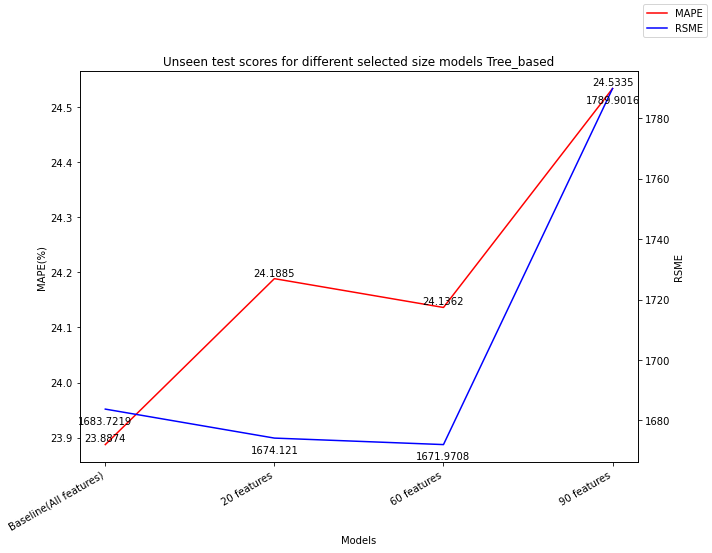

In [374]:
fig, ax1 = plt.subplots(figsize = (10,8))
plt.title("Unseen test scores for different selected size models Tree_based")
ax2 = ax1.twinx()
x =  ["Baseline(All features)","20 features","60 features","90 features"]
y = [round(i*100,4) for i in[MAPE_result_valid,MAPE_result_90tb,MAPE_result_60tb,MAPE_result_20tb]]
y2 = [round(i,4) for i in[RSME_result_valid,RSME_result_90tb,RSME_result_60tb,RSME_result_20tb]]
ax1.plot(x,y,color ='red', label = 'MAPE')
ax2.plot(x,y2,color ='blue',label = 'RSME')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAPE(%)')
ax2.set_ylabel('RSME')

for i in range(len(x)):
    ax1.text(i, y[i]+0.005, y[i], ha = 'center')
    ax2.text(i, y2[i]- 5, y2[i], ha = 'center')

fig.legend(loc="upper right")


fig.autofmt_xdate()

plt.show()

# Hypermeter tunning

In [375]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [376]:
max_depth = [training_set.shape[1]*0.1,training_set.shape[1]*0.5,training_set.shape[1]*0.8,training_set.shape[1]]
max_sample = [0.2,0.5,1]
parameters = {'n_estimators':[100,250,500], 'criterion':['mse', 'mae'], "max_depth": max_depth,"max_samples":max_sample}
metrics = {'r2':'r2','RMSE':'neg_root_mean_squared_error','neg_mean_absolute_percentage_error':'neg_mean_absolute_percentage_error'}
tscv = TimeSeriesSplit(n_splits=5)

In [377]:
tuning_reg = RandomForestRegressor()

In [378]:
clf = GridSearchCV(tuning_reg, parameters, cv = tscv,scoring = metrics,refit = 'RMSE',n_jobs = 2, verbose = 10000)

In [379]:
clf.fit(training_set, targets)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=2,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [5, 10, 15, 114],
                         'max_samples': [0.2, 0.5, 1],
                         'n_estimators': [100, 250, 500]},
             refit='RMSE',
             scoring={'RMSE': 'neg_root_mean_squared_error',
                      'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                      'r2': 'r2'},
             verbose=10000)

In [380]:
clf.best_estimator_

RandomForestRegressor(criterion='mae', max_depth=114, max_samples=0.5,
                      n_estimators=500)

In [381]:
clf.best_score_

-47.29395342824262

# Results evaluation on the unseen dataset after hyper parameters tuning

In [382]:
selected_re = RandomForestRegressor(criterion='mae', max_depth=114, max_samples=0.5,n_estimators=500)

In [383]:
selected_re.fit(training_set, targets)

RandomForestRegressor(criterion='mae', max_depth=114, max_samples=0.5,
                      n_estimators=500)

In [384]:
y_prediciton = selected_re.predict(X_valid[:1649],)
MAPE_result = mean_absolute_percentage_error(y_valid[:1649],y_prediciton)
RSME_result = mean_squared_error(y_valid[:1649], y_prediciton_60tb,squared = True)
print(MAPE_result)
print(RSME_result)

0.2486234498215605
1671.9707998787144
